TODO: かなりラフに書いたので後でまとめること

In [ ]:
## 同一ディレクトリ内にhttps://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g からダウンロードした学習済み単語ベクトルを配置しているものとする

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from gensim.models import KeyedVectors

DATASETPATH = '/content/drive/MyDrive/Colab Notebooks/NLP100/GoogleNews-vectors-negative300.bin' 

wv = KeyedVectors.load_word2vec_format(DATASETPATH, binary=True)

In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2023-01-27 13:41:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  34.4MB/s    in 0.8s    

2023-01-27 13:41:45 (34.4 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [6]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [7]:
# 50の内容を複製

import random

TARGET_PUBLISHERS = [
  'Reuters',\
  'Huffington Post',\
  'Businessweek',\
  'Contactmusic.com',\
  'Daily Mail'
]

with open('./newsCorpora.csv') as f:
   all_news = [news for news in f.readlines() if news.split('\t')[3] in TARGET_PUBLISHERS]

random.shuffle(all_news)

train_data_num = len(all_news)  * 8 // 10
valid_data_num = len(all_news)  * 9 // 10
train_data = all_news[: train_data_num]
valid_data = all_news[train_data_num : valid_data_num]
test_data = all_news[valid_data_num :]

In [8]:
# 70
import numpy as np


NEWS_CATEGORIES = {
    'b' : 0,
    't' : 1,
    'e' : 2,
    'm' : 3
}


def vector_create(X, filepath):
  for x in X:
    news = x.split("\t")
    title, category = news[1], news[4]
    word_v = None
    for word in title.split(' '):
      if word:
        try:
          if word_v:
            word_v = word_v + wv[word] #. most_similarで抽出しようとするとメモリが死ぬため、データセットに存在する場合のみ扱う
          else:
            word_v = wv[word]
        except:
          continue
    if word_v is None:
      word_v = np.zeros(300)
    with open(f'./{filepath}_x.csv', mode='a') as f:
        f.write(str(','.join(list([str(char) for char in word_v]))) + '\n')
    y = NEWS_CATEGORIES[news[4]]
    with open(f'./{filepath}_y.csv', mode='a') as f:
      f.write(str(y) + '\n')

vector_create(train_data, 'train')
vector_create(valid_data, 'valid')
vector_create(test_data, 'test')

In [9]:
# 71
import csv
from scipy.special import softmax


X_14 = []
with open(f'./train_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    if i == 4:
      break
    X_14.append(row)
    i += 1
  X_14 = np.array(X_14, dtype=np.float64)

W = np.zeros((X_14.shape[1], len(NEWS_CATEGORIES)))

y_hat1 = softmax(np.dot(X_14[0], W))
print(f'y_hat1: {y_hat1}')
Y_hat = softmax(np.dot(X_14, W))
print(f'Y_hat: {Y_hat}')


y_hat1: [0.25 0.25 0.25 0.25]
Y_hat: [[0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]
 [0.0625 0.0625 0.0625 0.0625]]


In [11]:
# 72
Y_14 = []
with open(f'./train_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    if i == 4:
      break
    Y_14.append(int(row.strip()))
    i += 1
Y_14 = np.array(Y_14)
l1 = np.log(Y_hat[Y_14[0]])
print(f'l1: {l1}')
gradient1 = (Y_14[0] - Y_hat[0][Y_14[0]]) * X_14[0]
print(f'gradient1: {gradient1}')

l1: [-2.77258872 -2.77258872 -2.77258872 -2.77258872]
gradient1: [ 0.21002198  0.45220948  0.09980774  0.21096802  0.11447143 -0.09318542
 -0.10406494 -0.31030273  0.40679932  0.21096802  0.41815185  0.50708008
 -0.32165526 -0.11920166 -0.12393189  0.1494751   0.36138917 -0.10548401
  0.48815917  0.38220214 -0.07804871 -0.23840332  0.31030273  0.41436768
 -0.17501831 -0.48059083  0.47680664 -0.05510712 -0.05250549 -0.09507752
  0.05368805  0.20718384  0.31597901 -0.0737915   0.45599365 -0.1873169
 -0.23840332  0.22421265  0.05770874 -0.11872864 -0.32733154  0.16934204
 -0.03050995  0.43896484  0.36517333 -0.36328125  0.28192138  0.57519531
 -0.00304508  0.68115234 -0.27435302  0.62438964 -0.6168213  -1.09741211
 -0.60925292  0.59033203  0.32543945 -0.18447876 -0.41815185 -0.10643005
  0.28759766  0.55627442 -0.45220948 -0.49572755 -0.07804871 -0.4673462
 -0.15325927 -0.74926758  0.51843261  0.05628967 -0.00946045  0.34057617
 -0.22421265  0.0695343  -0.19299316  0.23556518  0.26678466 

In [12]:
ls = []
for i in range(4):
  l = -1 * np.log(Y_hat[Y_14[i]])
  ls.append(l)
gradient = gradient1
print(np.average(l))
for i in range(1,4):
  gradient += (Y_14[i] - Y_hat[i][Y_14[i]]) * X_14[i]
gradient = gradient / 4
print(f'gradient: {gradient}')

2.772588722239781
gradient: [ 4.84695447e-02  1.15346910e-01  2.00462341e-02  4.44412238e-02
  3.56369012e-02 -2.28614807e-02 -2.21939090e-02 -7.05089569e-02
  1.07848169e-01  4.97436530e-02  1.10449790e-01  1.27222061e-01
 -7.87048317e-02 -2.79150011e-02 -2.39934923e-02  3.20510877e-02
  9.58480846e-02 -2.66418460e-02  1.20162961e-01  9.89074684e-02
 -1.90277099e-02 -6.34155273e-02  7.05184938e-02  9.96551527e-02
 -4.36401360e-02 -1.29019740e-01  1.26808167e-01 -2.73571015e-02
 -1.16786960e-02 -3.78074649e-02  8.37135319e-03  5.72433472e-02
  7.12585461e-02 -1.44958498e-02  1.11485480e-01 -4.25109877e-02
 -5.18188476e-02  6.16168975e-02  1.77764892e-02 -2.04124450e-02
 -7.87124623e-02  4.37717438e-02 -1.10988616e-02  9.77630614e-02
  8.59260546e-02 -8.89587402e-02  7.87658680e-02  1.36291504e-01
 -3.42011455e-03  1.65016174e-01 -6.03256212e-02  1.48996351e-01
 -1.52532580e-01 -2.78146744e-01 -1.43035886e-01  1.38290405e-01
  9.34906006e-02 -4.22363283e-02 -1.03294371e-01 -2.00805662e-

In [13]:
# 73

EPOCH = 100

X = []
with open(f'./train_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    X.append(row)
    i += 1
X = np.array(X, dtype=np.float64)

W = np.zeros((len(NEWS_CATEGORIES), X_14.shape[1]))

Y = []
with open(f'./train_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    Y.append(add_row)
    i += 1
Y = np.array(Y)

eta = 1.0
for i in range(EPOCH):
  i = np.random.randint(0, X.shape[0])
  y_hat = softmax(np.dot(W, X[i]))
  grad = Y[i] - y_hat
  for j in range(grad.shape[0]):
    W[j] += eta * grad[j] * X[i]
print(W)

[[-0.41490573 -0.20554271 -0.93470456 ... -1.03232535  0.63409774
   0.82805858]
 [ 0.98673899 -0.28574666  0.01308324 ...  0.01967559 -1.38415
  -0.64282137]
 [ 0.02141252  0.31306271  0.19188612 ...  0.75180286 -0.22455328
   0.04309412]
 [-0.59324578  0.17822667  0.7297352  ...  0.2608469   0.97460555
  -0.22833133]]


In [14]:
# 74
correct = 0
for i in range(X.shape[0]):
  p = softmax(np.dot(W, X[i]))
  index = np.where(p == np.max(p))
  if (Y[i][index] == 1)[0]:
    correct += 1
print(correct/X.shape[0])


0.5478285286409584


In [15]:
# 75

EPOCH = 100

X = []
with open(f'./train_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    X.append(row)
    i += 1
X = np.array(X, dtype=np.float64)


Y = []
with open(f'./train_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    Y.append(add_row)
    i += 1
Y = np.array(Y)

W = np.zeros((len(NEWS_CATEGORIES), X.shape[1]))


valid_X = []
with open(f'./valid_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    valid_X.append(row)
    i += 1
valid_X = np.array(valid_X, dtype=np.float64)

valid_Y = []
with open(f'./valid_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    valid_Y.append(add_row)
    i += 1
valid_Y = np.array(valid_Y)


eta = 1.0
train_losses = []
train_correctness = []
test_losses = []
test_correctness = []
for i in range(EPOCH):
  i = np.random.randint(0, X.shape[0])
  y_hat = softmax(np.dot(W, X[i]))
  index = np.where(Y[i] == 1)
  l = -1 * np.log(y_hat[index])
  grad = Y[i] - y_hat
  for j in range(grad.shape[0]):
    W[j] += eta * grad[j] * X[i]
  correct = 0
  l = 0
  for i in range(X.shape[0]):
    p = softmax(np.dot(W, X[i]))
    index = np.where(Y[i] == 1)
    l = -1 * np.log(p[index])
    max_index = np.where(p == np.max(p))
    if (Y[i][max_index] == 1)[0]:
      correct += 1
  train_losses.append(l)
  train_correctness.append(correct/X.shape[0])

  correct = 0
  l = 0
  for i in range(valid_X.shape[0]):
    p = softmax(np.dot(W, valid_X[i]))
    index = np.where(valid_Y[i] == 1)
    l = -1 * np.log(p[index])
    max_index = np.where(p == np.max(p))
    if (valid_Y[i][max_index] == 1)[0]:
      correct += 1
  test_losses.append(l)
  test_correctness.append(correct/valid_X.shape[0])


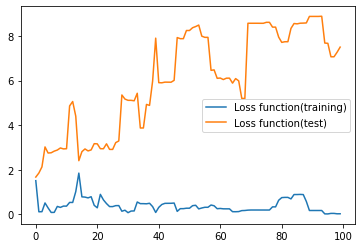

In [16]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(EPOCH)], train_losses, label="Loss function(training)")
plt.plot([i for i in range(EPOCH)], test_losses, label="Loss function(test)")

plt.legend()
plt.show()

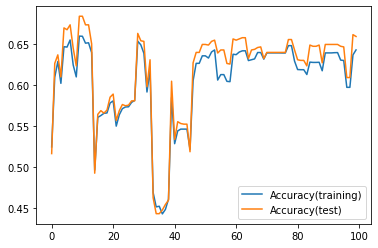

In [18]:
plt.plot([i for i in range(EPOCH)], train_correctness, label="Accuracy(training)")
plt.plot([i for i in range(EPOCH)], test_correctness, label="Accuracy(test)")

plt.legend()
plt.show()

In [19]:
#76
import csv


EPOCH = 100

X = []
with open(f'./train_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    X.append(row)
    i += 1
X = np.array(X, dtype=np.float64)


Y = []
with open(f'./train_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    Y.append(add_row)
    i += 1
Y = np.array(Y)

W = np.zeros((len(NEWS_CATEGORIES), X.shape[1]))


valid_X = []
with open(f'./valid_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    valid_X.append(row)
    i += 1
valid_X = np.array(valid_X, dtype=np.float64)

valid_Y = []
with open(f'./valid_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    valid_Y.append(add_row)
    i += 1
valid_Y = np.array(valid_Y)


eta = 1.0
with open(f'./checkpoint.csv', mode='a') as f:
  writer = csv.writer(f)
  writer.writerow(['epoch', 'W', 'l', 'grad'])
for i in range(EPOCH):
  i = np.random.randint(0, X.shape[0])
  y_hat = softmax(np.dot(W, X[i]))
  index = np.where(Y[i] == 1)
  l = -1 * np.log(y_hat[index])
  grad = Y[i] - y_hat
  for j in range(grad.shape[0]):
    W[j] += eta * grad[j] * X[i]
  with open(f'./checkpoint.csv', mode='a') as f:
    writer = csv.writer(f)
    writer.writerow([i, W, l, grad])


In [20]:
# 77 
import time


EPOCH = 100
B = [1, 2, 4, 8, 16, 32]

X = []
with open(f'./train_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    X.append(row)
    i += 1
X = np.array(X, dtype=np.float64)


Y = []
with open(f'./train_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    Y.append(add_row)
    i += 1
Y = np.array(Y)

W = np.zeros((len(NEWS_CATEGORIES), X.shape[1]))


valid_X = []
with open(f'./valid_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    valid_X.append(row)
    i += 1
valid_X = np.array(valid_X, dtype=np.float64)

valid_Y = []
with open(f'./valid_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    valid_Y.append(add_row)
    i += 1
valid_Y = np.array(valid_Y)


eta = 1.0
for b in B:
  start_at = time.perf_counter()
  l = 0
  for i in range(EPOCH):
    ls = []
    grad = None
    for j in range(b):
      i = np.random.randint(0, X.shape[0])
      y_hat = softmax(np.dot(W, X[i]))
      index = np.where(Y[i] == 1)
      ls.append(-1 * np.log(y_hat[index]))
      if grad is not None:
        grad = grad + (Y[i] - y_hat)
      else:
          grad = Y[i] - y_hat
    l += sum(ls) / b
    grad = grad / b
    for j in range(grad.shape[0]):
      W[j] += eta * grad[j] * X[i]
  end_at = time.perf_counter()
  print(f'Batch {b}: {end_at - start_at}')


Batch 1: 0.016693071000076998
Batch 2: 0.03800438199994005
Batch 4: 0.04392093100000238
Batch 8: 0.04579446500008544
Batch 16: 0.10916968100002578
Batch 32: 0.177513941999905


In [ ]:
# 78


In [23]:
# 79


EPOCH = 100

X = []
with open(f'./train_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    X.append(row)
    i += 1
X = np.array(X, dtype=np.float64)


Y = []
with open(f'./train_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    Y.append(add_row)
    i += 1
Y = np.array(Y)

W = np.zeros((len(NEWS_CATEGORIES), X.shape[1]))

B = np.array([0.1, 0.1, 0.1, 0.1])


valid_X = []
with open(f'./valid_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    valid_X.append(row)
    i += 1
valid_X = np.array(valid_X, dtype=np.float64)

valid_Y = []
with open(f'./valid_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    add_row = [0] * len(NEWS_CATEGORIES)
    add_row[int(row.strip())] =1
    valid_Y.append(add_row)
    i += 1
valid_Y = np.array(valid_Y)


eta = 1.0
train_losses = []
train_correctness = []
test_losses = []
test_correctness = []
for i in range(EPOCH):
  i = np.random.randint(0, X.shape[0])
  y_hat = softmax(np.dot(W, X[i]) + B)
  index = np.where(Y[i] == 1)
  l = -1 * np.log(y_hat[index])
  grad = Y[i] - y_hat
  for j in range(grad.shape[0]):
    W[j] += eta * grad[j] * X[i]
  correct = 0
  l = 0
  for i in range(X.shape[0]):
    p = softmax(np.dot(W, X[i]))
    index = np.where(Y[i] == 1)
    l = -1 * np.log(p[index])
    max_index = np.where(p == np.max(p))
    if (Y[i][max_index] == 1)[0]:
      correct += 1
  train_losses.append(l)
  train_correctness.append(correct/X.shape[0])

  correct = 0
  l = 0
  for i in range(valid_X.shape[0]):
    p = softmax(np.dot(W, valid_X[i]))
    index = np.where(valid_Y[i] == 1)
    l = -1 * np.log(p[index])
    max_index = np.where(p == np.max(p))
    if (valid_Y[i][max_index] == 1)[0]:
      correct += 1
  test_losses.append(l)
  test_correctness.append(correct/valid_X.shape[0])




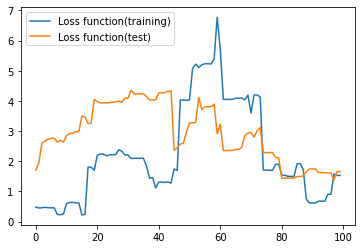

In [24]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(EPOCH)], train_losses, label="Loss function(training)")
plt.plot([i for i in range(EPOCH)], test_losses, label="Loss function(test)")

plt.legend()
plt.show()

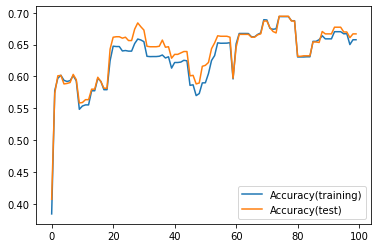

In [25]:
plt.plot([i for i in range(EPOCH)], train_correctness, label="Accuracy(training)")
plt.plot([i for i in range(EPOCH)], test_correctness, label="Accuracy(test)")

plt.legend()
plt.show()